# Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import mean_squared_error, make_scorer, r2_score, mean_absolute_error, mean_squared_log_error









import warnings
warnings.filterwarnings("ignore")


# Read file

In [3]:
#Read and fast visualize the data 
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
df = pd.read_csv("clean_housing_data.csv")
print("Shape: ",df.shape)
df.head()

Shape:  (57003, 21)


,yearMonth_sale,case_type_dk,zip_code_name,erts89_utm32_x,erts89_utm32_y,ed50_x,ed50_y,wgs84_lat,wgs84_lon,residental_area,measured_area,energy_labeled_required,energy_labeled,amount_of_toilets,year_of_construction,renovation_year,first_offer_price,lastest_announced_price,sold_price,days_on_the_market_all_broker,change_broker
0,201805,Rækkehus,København Ø,724656.3099617342,6177510.129902037,724738.3771995398,6177716.274317907,"55,69125957","12,57452761",121,136.0,True,c,2,1882,0,9895000,9500000,8500000,79,0
1,201805,Rækkehus,København Ø,724612.6998841494,6177539.480294425,724694.7669242901,6177745.625006782,"55,69154296","12,57385928",136,151.0,True,c,2,1882,1,9595000,9195000,8750000,96,0
2,202006,Villa,København S,726339.2701369224,6172005.4193364065,726421.3337691108,6172211.5248479135,"55,64111328","12,59671021",107,126.0,True,d,1,1927,0,4195000,3995000,3900000,148,0
3,202103,Villa,København S,726314.7447286966,6171972.668490626,"726396,8081",6172178.773859339,"55,64083099","12,5962944",140,136.0,True,a,2,2017,0,7495000,7495000,7595000,17,0
4,201108,Villa,Brønshøj,718735.9998927611,6178448.999985718,718818.0324674495,6178655.165567457,"55,70238375","12,48127579",87,259.0,True,g,2,1928,0,2250000,2250000,2275000,15,0


# Prepare data for train_test_split

In [4]:
# For the moment we will not use the latitude and longitud
excluded_cols = ["erts89_utm32_x", "erts89_utm32_y", "ed50_x",
                 "ed50_y", "wgs84_lat", "wgs84_lon"]

#Drop those columns from the data set - IN CASE WE USE THEM DELETE THIS CELL
df = df.drop(excluded_cols, axis=1)





In [5]:
#experimental df to use later on
df_prompt= pd.read_csv("clean_housing_data.csv")
df_prompt = df_prompt.drop(excluded_cols, axis=1)
df_prompt = df_prompt.drop("sold_price", axis=1)

# Get dummies for categorical values

We need to check if there are any categorical features that need hot encoding for some of the machine learning models. 
One way to do this is by checking the data types of the columns:

In [6]:

#Find Categorical columns & save them in a variable
categorical_cols = [col for col in df.columns if df[col].dtype == "object"]

#Get dummies for those categorical columns
if categorical_cols:
    df = pd.get_dummies(df, columns=categorical_cols)

#Print the new shape of DF with dummies
print("This is the shape with the dummies:", df.shape)

This is the shape with the dummies: (57003, 37)


# Split data

In [38]:
#Save feature data in X
X = df.drop("sold_price", axis=1)

#Save target in y
y = df["sold_price"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y , random_state=42)


# Scaled data

First, The standard scaler is created in case it lead to better results

In [39]:

# Creating the scaler variable
scaler = StandardScaler()
#the scaler needs to be trained only in the training data and not in the test data, so it needs to be fit in there.
# What this will do is to adapt to all the values from the training set and create the new parameters dividing 
# all the numbers by the Max number found in the trianig data set
scaler.fit(X_train)

# Once the scaler variable has all the relative numbers, i can transform all the features so my new X_train_scaled will 
# only have numbers potencially between 0-1. On the test data we might find numbers higher than one or just smaller since 
# it will be divided by the higher number in the trainig set
X_train_standard_scaled = scaler.transform(X_train)
X_test_standard_scaled = scaler.transform(X_test) 

MinMax scaler

In [40]:
#Creating the MinMax scaler
scaler2= MinMaxScaler(feature_range=(0, 1))

#Fitting to the training feature data
scaler2.fit(X_train)

#Transforming the feature training and testing data
X_train_MinMax_scaled=scaler2.transform(X_train)
X_test_MinMax_scaled=scaler2.transform(X_test)

# Functions

### Print Linear y incercept & coeff

In [10]:

def print_model_coef(model):
    # Training set scores

    #coeficient of the model
    print("Linear model coeff (w):{}".format(model.coef_))

    #Intercept of the model
    print("Linear model intercept (b): {:.3f}".format(model.intercept_))
   


### Funtion to evaluate R2 and RMSLE for the regression models 

In [11]:


def evaluate_regression_model(model, X_train, y_train, X_test, y_test):
    # Making predictions on training and testing data
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculating evaluation metrics
    train_rmsle = np.sqrt(mean_squared_log_error(y_train, y_train_pred))
    test_rmsle = np.sqrt(mean_squared_log_error(y_test, y_test_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # Formatting the results to three decimal places
    train_rmsle = format(train_rmsle, ".3f")
    test_rmsle = format(test_rmsle, ".3f")
    train_r2 = format(train_r2, ".3f")
    test_r2 = format(test_r2, ".3f")

    # Creating a table of results
    table = [["Metric", "Training", "Testing"],
             ["RMSLE", train_rmsle, test_rmsle],
             ["R-squared", train_r2, test_r2]]

    # Returning the table as a string
    return tabulate(table, headers="firstrow", tablefmt="fancy_grid")


### EVALUATE R2 and RMSLE for the regression models when the scaled data presents negative values

In [12]:
def evaluate_regression_model_neg(model, X_train, y_train, X_test, y_test):
    # Applying transformation to target variable
    y_train_transformed = np.log1p(y_train)
    y_test_transformed = np.log1p(y_test)

    # Fitting the model with transformed target variable
    model.fit(X_train, y_train_transformed)

    # Making predictions on training and testing data
    y_train_pred_transformed = model.predict(X_train)
    y_test_pred_transformed = model.predict(X_test)

    # Applying inverse transformation to predicted values
    y_train_pred = np.expm1(y_train_pred_transformed)
    y_test_pred = np.expm1(y_test_pred_transformed)

    # Calculating evaluation metrics
    train_rmsle = np.sqrt(mean_squared_log_error(y_train, y_train_pred))
    test_rmsle = np.sqrt(mean_squared_log_error(y_test, y_test_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # Formatting the results to three decimal places
    train_rmsle = format(train_rmsle, ".3f")
    test_rmsle = format(test_rmsle, ".3f")
    train_r2 = format(train_r2, ".3f")
    test_r2 = format(test_r2, ".3f")

    # Creating a table of results
    table = [["Metric", "Training", "Testing"],
             ["RMSLE", train_rmsle, test_rmsle],
             ["R-squared", train_r2, test_r2]]

    # Returning the table as a string
    return tabulate(table, headers="firstrow", tablefmt="fancy_grid")
    # Returning the table as a string
    return tabulate(table, headers="firstrow", tablefmt="fancy_grid")



### Function to plot graph of regression line between actual sold price and predicted price for testing data (unseen data)

In [13]:

def plot_actual_vs_predicted_test(model,X_test,y_test):
    y_actual = y_test  # Actual target values from your dataset - test set
    y_predicted = model.predict(X_test)  # Predicted target values from your regression model - test set
    
    plt.figure(figsize=(8, 6))
    plt.scatter(y_actual, y_predicted, s=20, color='blue', alpha=0.5)
    plt.plot([min(y_actual), max(y_actual)], [min(y_actual), max(y_actual)], color='red', linestyle='--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs. Predicted Values')
    plt.show()


### Plot feature importance

In [14]:

def plot_feature_importance(model, df):
    # Get feature names from the DataFrame columns
    feature_names = df.columns.values

    if isinstance(model, RandomForestRegressor):
        feature_importance = model.feature_importances_
    elif isinstance(model, LinearRegression):
        feature_importance = np.abs(model.coef_)
    elif isinstance(model, MLPRegressor):
        # Retrieve the sum of squared weights for each feature in the input layer
        input_weights = np.sum(np.square(model.coefs_[0]), axis=0)
        feature_importance = input_weights / np.sum(input_weights)  # Normalize the weights
    else:
        raise ValueError("Model not supported for feature importance analysis.")

    # Sort feature importance values in descending order
    sorted_indices = np.argsort(feature_importance)[::-1]
    sorted_importance = feature_importance[sorted_indices]
    sorted_names = feature_names[sorted_indices]

    # Create horizontal bar plot
    plt.figure(figsize=(16, 10))
    plt.barh(range(len(sorted_importance)), sorted_importance, align='center')
    plt.yticks(range(len(sorted_importance)), sorted_names)
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance Plot')
    plt.show()


### Plot Distribution of residuals

In [15]:

def plot_residuals_distribution(model, X_test, y_test):

    y_actual = y_test  # Actual target values from your dataset - test set
    y_predicted = model.predict(X_test)  # Predicted target values from your regression model - test set
    
    # Calculate residuals
    residuals = y_actual - y_predicted

    # Plot the distribution of residuals
    plt.figure(figsize=(8, 6))
    sns.histplot(residuals, kde=True)
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Distribution of Residuals')
    plt.show()


# Simple Linear regression model
This simple least squared regression has no way to control the model complexity without using ridge 

### Non Scaled data with a fast evaluation

In [171]:
#Creating the model and fitting it in the non-scaled data
linear_reg=LinearRegression().fit(X_train, y_train)

In [172]:
results_linear_reg=evaluate_regression_model(linear_reg, X_train, y_train, X_test, y_test)
print("Results of evaluation on non-Scaled data fit into linear regression model \n ")

print(results_linear_reg)


Results of evaluation on non-Scaled data fit into linear regression model 
 
╒═══════════╤════════════╤═══════════╕
│ Metric    │   Training │   Testing │
╞═══════════╪════════════╪═══════════╡
│ RMSLE     │      0.052 │     0.052 │
├───────────┼────────────┼───────────┤
│ R-squared │      0.992 │     0.993 │
╘═══════════╧════════════╧═══════════╛


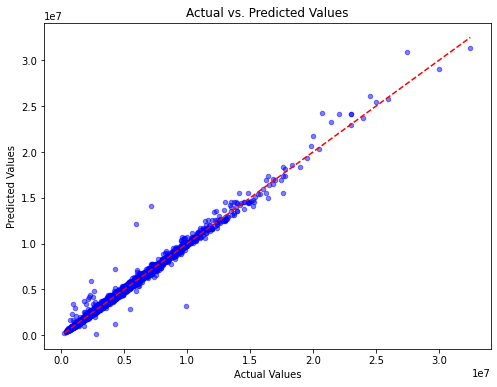

In [176]:
# Plot the scatter plot of actual vs. predicted values on the testing data - NON SCALED
plot_actual_vs_predicted_test(linear_reg,X_test, y_test)


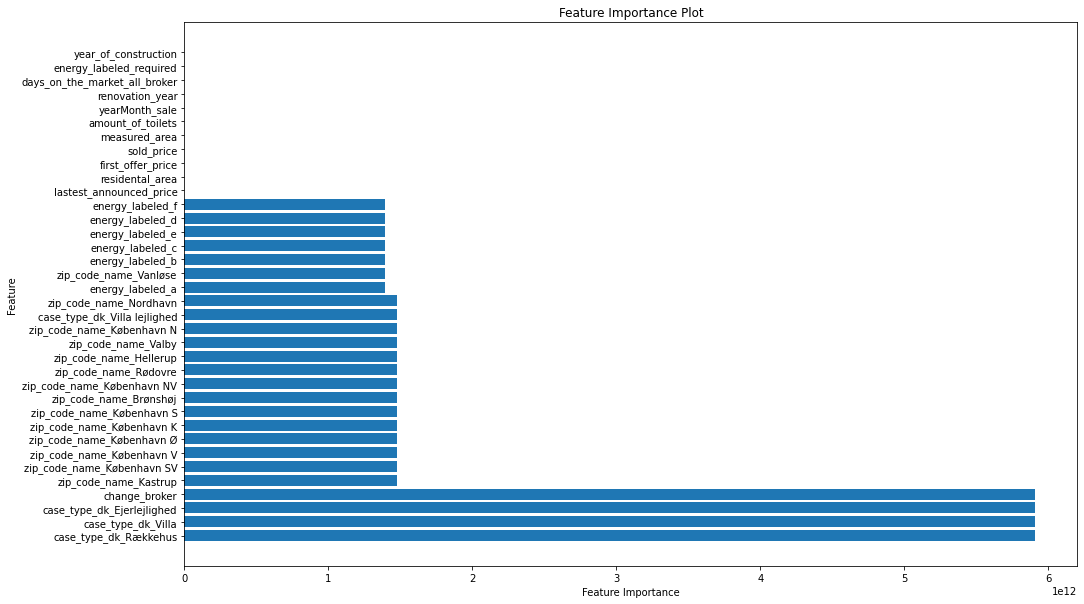

In [187]:
#Plot feature importance for linear regression

plot_feature_importance(linear_reg,df)

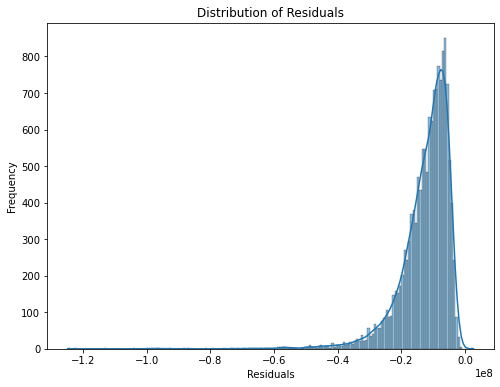

In [190]:
#Plot of residuals values for NON SCALED DATA
plot_residuals_distribution(linear_reg,X_test,y_test)

### MinMax scaled data

In [192]:
#Creating the model and fitting it in the standard scaled data
linear_reg_st=LinearRegression().fit(X_train_MinMax_scaled, y_train)


In [193]:
results_linear_reg_st=evaluate_regression_model_neg(linear_reg, X_train_MinMax_scaled, y_train, X_test_MinMax_scaled, y_test)
print("Results of evaluation on Scaled data fit into linear regression model \n ")
print(results_linear_reg)

Results of evaluation on Scaled data fit into linear regression model 
 
╒═══════════╤════════════╤═══════════╕
│ Metric    │   Training │   Testing │
╞═══════════╪════════════╪═══════════╡
│ RMSLE     │      0.052 │     0.052 │
├───────────┼────────────┼───────────┤
│ R-squared │      0.992 │     0.993 │
╘═══════════╧════════════╧═══════════╛


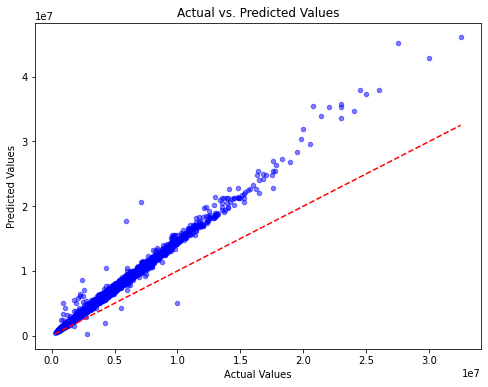

In [194]:
# Plot the scatter plot of actual vs. predicted values on the testing data - MinMax SCALED
plot_actual_vs_predicted_test(linear_reg_MinMax_scaled,X_test_MinMax_scaled, y_test)


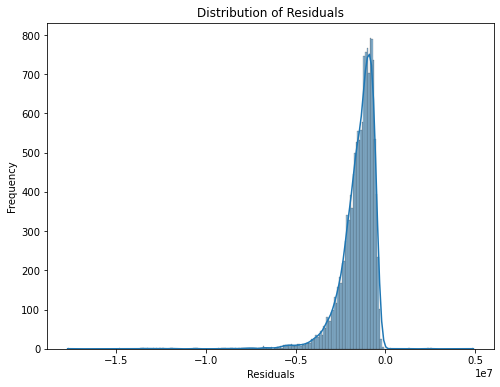

In [191]:
#Plot of residuals values for NON SCALED DATA

plot_residuals_distribution(linear_reg_MinMax_scaled,X_test_MinMax_scaled,y_test)

# Ridge Regression model  

In [199]:
#Create ridge model alpha=1 default value 
ridge_reg=Ridge(alpha=1).fit(X_train, y_train)

#Print the results of RMSLE and R2 for this fit.
results_ridge_reg=evaluate_regression_model(ridge_reg,X_train, y_train,X_test,y_test)
print("Results of evaluation on non-Scaled data fit into Ridge linear regression model \n ")

print(results_ridge_reg)


Results of evaluation on non-Scaled data fit into Ridge linear regression model 
 
╒═══════════╤════════════╤═══════════╕
│ Metric    │   Training │   Testing │
╞═══════════╪════════════╪═══════════╡
│ RMSLE     │      0.052 │     0.052 │
├───────────┼────────────┼───────────┤
│ R-squared │      0.992 │     0.993 │
╘═══════════╧════════════╧═══════════╛


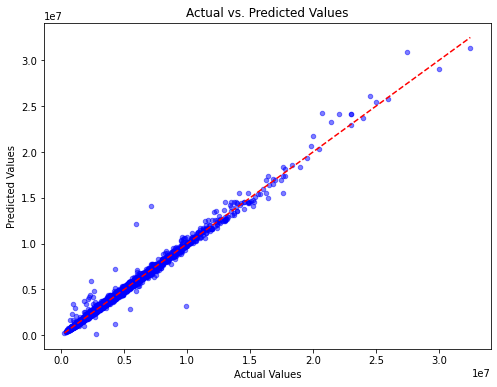

In [202]:
# Plot the scatter plot of actual vs. predicted values on the testing data - NON SCALED DATA
plot_actual_vs_predicted_test(ridge_reg,X_test, y_test)


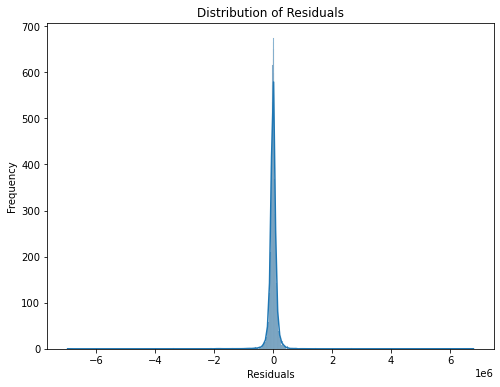

In [200]:
#Plot of residuals values for NON SCALED DATA

plot_residuals_distribution(ridge_reg,X_test,y_test)

### Different Ridge models with no regularization

In [212]:
#Create & fit model for the MinMax scaled data
ridge_reg_MinMax=Ridge().fit(X_train_MinMax_scaled, y_train)

#Print the results of RMSLE and R2 for this fit.
results_ridge_reg_MinMax=evaluate_regression_model(ridge_reg_MinMax,X_train_MinMax_scaled, y_train,X_test_MinMax_scaled,y_test)
print("Results of evaluation on Scaled data fit into Ridge linear regression model \n ")

print(results_ridge_reg_MinMax)

Results of evaluation on Scaled data fit into Ridge linear regression model 
 
╒═══════════╤════════════╤═══════════╕
│ Metric    │   Training │   Testing │
╞═══════════╪════════════╪═══════════╡
│ RMSLE     │      0.054 │     0.054 │
├───────────┼────────────┼───────────┤
│ R-squared │      0.991 │     0.992 │
╘═══════════╧════════════╧═══════════╛


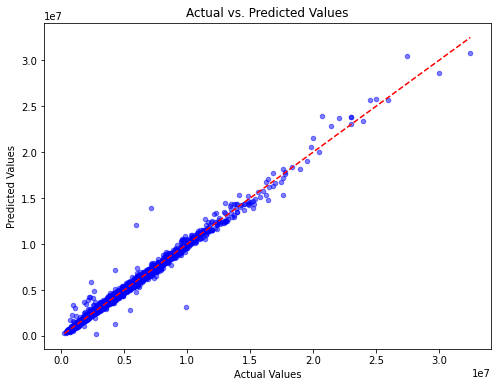

In [214]:
# Plot the scatter plot of actual vs. predicted values on the testing data - NON SCALED DATA
plot_actual_vs_predicted_test(ridge_reg_MinMax,X_test_MinMax_scaled, y_test)

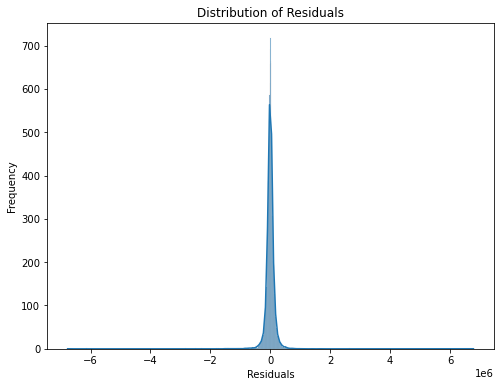

In [215]:
#Plot of residuals values for SCALED DATA - Ridge

plot_residuals_distribution(ridge_reg_MinMax,X_test_MinMax_scaled,y_test)

### Cross validation + hyperparameter tunning for Ridge Model

In [27]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import make_scorer, mean_squared_log_error, r2_score
import numpy as np

# Define your X and y variables

# Specify the parameter grid for the Ridge model
param_grid = {'alpha': [0.001, 0.01 ,0.1, 1.0, 10.0], 'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}

# Create a Ridge model
ridge = Ridge()

# Define the evaluation metrics
scoring = {'r2': make_scorer(r2_score), 'rmsle': make_scorer(mean_squared_log_error, greater_is_better=False)}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid, scoring=scoring, refit='r2')

# Perform cross-validation with GridSearchCV
predicted = cross_val_predict(grid_search, X, y, cv=5)

# Calculate RMSLE for training set
rmsle_train = np.sqrt(mean_squared_log_error(y, predicted))

# Fit the best model on the entire training set
grid_search.fit(X, y)

# Get the best parameter values
best_params = grid_search.best_params_

# Predict using the best model
y_pred = grid_search.predict(X)

# Calculate RMSLE for test set
rmsle_test = np.sqrt(mean_squared_log_error(y, y_pred))

# Calculate R2 score for training set
r2_train = r2_score(y, predicted)

# Calculate R2 score for test set
r2_test = r2_score(y, y_pred)

print("Best Parameters:", best_params)

print("RMSLE (Training Set):", rmsle_train)
print("RMSLE (Test Set):", rmsle_test)

print("R2 Score (Training Set):", r2_train)
print("R2 Score (Test Set):", r2_test)


Best Parameters: {'alpha': 0.001, 'solver': 'svd'}
RMSLE (Training Set): 0.05241001436736615
RMSLE (Test Set): 0.05209718312181575
R2 Score (Training Set): 0.992231721224194
R2 Score (Test Set): 0.992313093369644


In [36]:
#Create & fit model for the new tunned parameters
ridge_reg_tunned=Ridge(alpha=0.001, solver="svd").fit(X_train, y_train)

#Print the results of RMSLE and R2 for this new fit. 

results_ridge_reg_tunned=evaluate_regression_model(ridge_reg_tunned,X_train, y_train,X_test,y_test)
print("Results of evaluation on Scaled data fit into Ridge linear regression model \n ")

print(results_ridge_reg_tunned)

Results of evaluation on Scaled data fit into Ridge linear regression model 
 
╒═══════════╤════════════╤═══════════╕
│ Metric    │   Training │   Testing │
╞═══════════╪════════════╪═══════════╡
│ RMSLE     │      0.052 │     0.055 │
├───────────┼────────────┼───────────┤
│ R-squared │      0.992 │     0.992 │
╘═══════════╧════════════╧═══════════╛


In [44]:
#Create & fit model for the new tunned parameters
ridge_reg_tunned_scaled=Ridge(alpha=0.001, solver="svd").fit(X_train_MinMax_scaled, y_train)

#Print the results of RMSLE and R2 for this new fit. 

results_ridge_reg_tunned_scaled=evaluate_regression_model(ridge_reg_tunned_scaled,X_train_MinMax_scaled, y_train,X_test_MinMax_scaled,y_test)
print("Results of evaluation on Scaled data fit into Ridge linear regression model \n ")

print(results_ridge_reg_tunned_scaled)


Results of evaluation on Scaled data fit into Ridge linear regression model 
 
╒═══════════╤════════════╤═══════════╕
│ Metric    │   Training │   Testing │
╞═══════════╪════════════╪═══════════╡
│ RMSLE     │      0.052 │     0.052 │
├───────────┼────────────┼───────────┤
│ R-squared │      0.992 │     0.993 │
╘═══════════╧════════════╧═══════════╛


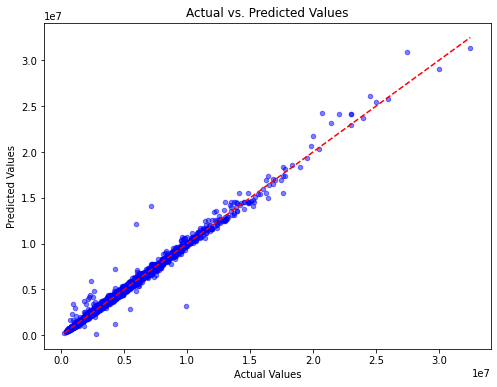

In [46]:
plot_actual_vs_predicted_test(ridge_reg_tunned_scaled,X_test_MinMax_scaled,y_test)

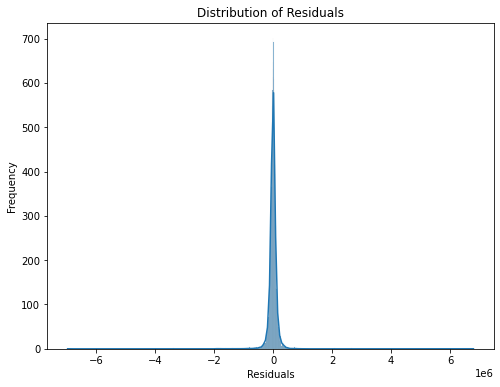

In [47]:
plot_residuals_distribution(ridge_reg_tunned_scaled,X_test_MinMax_scaled,y_test)

In [209]:


print("Ridge regression: effect of alpha regularization parameter\n")

resList = []
for alpha in [0.001,0.01, 0.1, 0.3, 1, 100, 200, 300, 1000, 3000]:
    clf = Ridge(alpha=alpha, random_state=0).fit(X_train, y_train)
    predictions = clf.predict(X_test)  
    res = (clf.score(X_test, y_test), clf.score(X_train, y_train),metrics.mean_absolute_error(y_test, predictions),metrics.mean_squared_error(y_test, predictions),np.sqrt(metrics.mean_squared_error(y_test, predictions)), alpha)
    resList.append(res)
    coeff_num= np.sum(abs(clf.coef_)) #sum all the coefficients to see if the alpha push it to zero, therefore, simplier model. 
   
resListSrt = sorted (resList,
                key = lambda e:e[0], reverse=True)

# Create a list of column names for the DataFrame
columns_results = ["Test", "Train", "MAE", "MSE", "RMSE", "alpha"]

# Create an empty DataFrame
df_results0 = pd.DataFrame(columns=columns_results)

for r in resListSrt:
    # Create a dictionary representing each row of data
    row = {
        "Test": r[0],
        "Train": r[1],
        "MAE": r[2],
        "MSE": r[3],
        "RMSE": r[4],
        "alpha": r[5]
    }
    # Append the row to the DataFrame
    df_results0 = df_results0.append(row, ignore_index=True)

# Print the DataFrame
df_results0






Ridge regression: effect of alpha regularization parameter



,Test,Train,MAE,MSE,RMSE,alpha
0,0.992668,0.992185,79362.586023,32405205649.17205,180014.459556,0.001
1,0.992668,0.992185,79362.573193,32405217740.478298,180014.49314,0.01
2,0.992668,0.992185,79362.445385,32405337254.069172,180014.825095,0.1
3,0.992668,0.992185,79362.164454,32405594046.499851,180015.538347,0.3
4,0.992667,0.992185,79361.211567,32406407546.170383,180017.797859,1.0
5,0.992664,0.992184,79291.694703,32422512124.201218,180062.52282,100.0
6,0.992662,0.992183,79238.005701,32431076097.436859,180086.301804,200.0
7,0.99266,0.992182,79198.747764,32439308022.56567,180109.155854,300.0
8,0.992648,0.992172,79103.432695,32492487496.447063,180256.726633,1000.0
9,0.992623,0.992147,79266.170152,32604792756.646568,180567.972677,3000.0


In [208]:

print("Ridge regression Standard scaled data: effect of alpha regularization parameter\n")


resList = []
for alpha in [0.001,0.01, 0.1, 0.3, 1, 100, 200, 300, 1000, 3000]:
    clf = Ridge(alpha=alpha, random_state=0).fit(X_train_standard_scaled, y_train)
    predictions = clf.predict(X_test)  
    res = (clf.score(X_test_standard_scaled, y_test), clf.score(X_train_standard_scaled, y_train),metrics.mean_absolute_error(y_test, predictions),metrics.mean_squared_error(y_test, predictions),np.sqrt(metrics.mean_squared_error(y_test, predictions)), alpha)
    resList.append(res)
    coeff_num= np.sum(abs(clf.coef_)) #sum all the coefficients to see if the alpha push it to zero, therefore, simplier model. 
   
resListSrt = sorted (resList,
                key = lambda e:e[0], reverse=True)


# Create an empty DataFrame
df_results1 = pd.DataFrame(columns=columns_results)

for r in resListSrt:
    # Create a dictionary representing each row of data
    row = {
        "Test": r[0],
        "Train": r[1],
        "MAE": r[2],
        "MSE": r[3],
        "RMSE": r[4],
        "alpha": r[5]
    }
    # Append the row to the DataFrame
    df_results1 = df_results1.append(row, ignore_index=True)

# Print the DataFrame
df_results1




Ridge regression Standard scaled data: effect of alpha regularization parameter



,Test,Train,MAE,MSE,RMSE,alpha
0,0.99267,0.992185,6823487521128.426758,66102927425589652194590720.0,8130370681930.169922,1.0
1,0.992668,0.992185,6822913543075.15918,66092890244644010979229696.0,8129753393839.447266,0.3
2,0.992668,0.992185,6822746560261.998047,66089969243319429979176960.0,8129573743027.332031,0.1
3,0.992668,0.992185,6822670978681.804688,66088646970750533598445568.0,8129492417780.493164,0.01
4,0.992668,0.992185,6822663405465.032227,66088514475395223493017600.0,8129484268721.799805,0.001
5,0.992449,0.991794,6835689609265.155273,66280222909885281904623616.0,8141266664953.634766,100.0
6,0.992267,0.991542,6811329004854.84082,65792083031200944986521600.0,8111231905894.500977,200.0
7,0.992148,0.991384,6780326271178.126953,65184987655390610726060032.0,8073722044719.561523,300.0
8,0.99152,0.990649,6550565102367.207031,60807177362686686833672192.0,7797895700936.675781,1000.0
9,0.988698,0.987679,6015876173396.319336,51230021424298943771049984.0,7157515031370.799805,3000.0


In [30]:
print("Ridge regression MinMax Scaled data: effect of alpha regularization parameter\n")

resList = []
for alpha in [0.001,0.01, 0.1, 0.3, 1, 100, 200, 300, 1000, 3000]:
    clf = Ridge(alpha=alpha, random_state=0).fit(X_train_MinMax_scaled, y_train)
    predictions = clf.predict(X_test)  
    res = (clf.score(X_test_MinMax_scaled, y_test), clf.score(X_train_MinMax_scaled, y_train),metrics.mean_absolute_error(y_test, predictions),metrics.mean_squared_error(y_test, predictions),np.sqrt(metrics.mean_squared_error(y_test, predictions)), alpha)
    resList.append(res)
    coeff_num= np.sum(abs(clf.coef_)) #sum all the coefficients to see if the alpha push it to zero, therefore, simplier model. 
   
resListSrt = sorted (resList,
                key = lambda e:e[0], reverse=True)





# Create an empty DataFrame
df_results2 = pd.DataFrame(columns=columns_results)

for r in resListSrt:
    # Create a dictionary representing each row of data
    row = {
        "Test": r[0],
        "Train": r[1],
        "MAE": r[2],
        "MSE": r[3],
        "RMSE": r[4],
        "alpha": r[5]
    }
    # Append the row to the DataFrame
    df_results2 = df_results2.append(row, ignore_index=True)

# Print the DataFrame
df_results2




Ridge regression MinMax Scaled data: effect of alpha regularization parameter



,Test,Train,MAE,MSE,RMSE,alpha
0,0.709282,0.754701,176361223787548.59375,43600077394346411927724359680.0,208806315503977.0625,0.01
1,0.709281,0.754706,176359508509965.59375,43603221689488381848334630912.0,208813844582892.5,0.001
2,0.709148,0.754521,176095106652455.9375,43450570862698375223070162944.0,208448005178026.0625,0.1
3,0.708937,0.75426,175022591252670.6875,42913669185278260674719383552.0,207156146868197.625,0.3
4,0.708657,0.753875,170868528225157.34375,40894655464456972148664172544.0,202224270216156.21875,1.0
5,0.636776,0.667641,53096018925527.351562,3934134703456458286651408384.0,62722680933267.335938,100.0
6,0.598018,0.623427,36306725534570.4375,1835321289947925545255698432.0,42840649971118.851562,200.0
7,0.568506,0.590597,28535338610690.585938,1131657291161259469524959232.0,33640114315520.085938,300.0
8,0.458144,0.471345,12813782282978.863281,226337866174752502130409472.0,15044529443447.292969,1000.0
9,0.34479,0.352642,5646543601985.118164,43529203457971199642959872.0,6597666516123.044922,3000.0


# Random Forest

### Basic Random Forest

In [31]:
# Create a random forest regressor & Fit 
rf_model = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_train, y_train)

In [32]:
# Make predictions on the testing data
y_pred = rf_model.predict(X_test)

# Calculate mean squared error
mse = metrics.mean_squared_error(y_test, y_pred)

# Calculate R-squared
r2 = metrics.r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)
print("Training Score", rf_model.score(X_train, y_train))
print("Test score;", rf_model.score(X_test,y_test))

Mean Squared Error: 2297865669836.418
R-squared: 0.6172336240469303
Training Score 0.9429654562090818
Test score; 0.6172336240469303


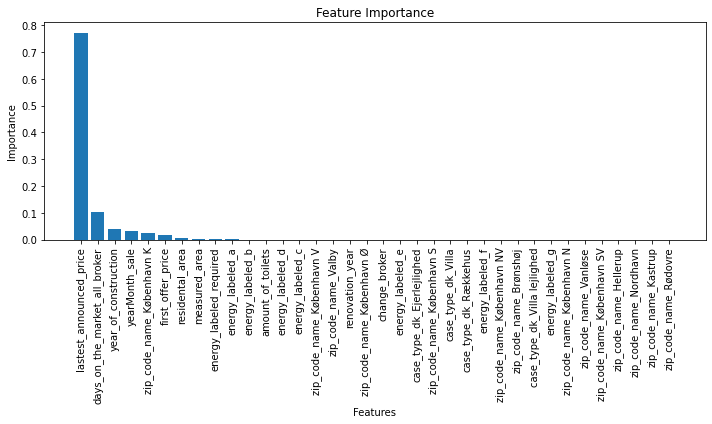

In [33]:
# Get feature importances
importances = rf_model.feature_importances_

# Get feature names
feature_names = X.columns

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance")
plt.tight_layout()
plt.show()


### Model optimization and regularization

In [34]:
# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)


Best Hyperparameters: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}


### Create a new model with the optimized values 

In [35]:
 # Create a random forest regressor & Fit 
rf_model = RandomForestRegressor(n_estimators=300, min_samples_leaf=4, max_depth=5, min_samples_split=10, random_state=42).fit(X_train, y_train)

In [36]:
# Make predictions on the testing data
y_pred = rf_model.predict(X_test)

# Calculate mean squared error
mse = metrics.mean_squared_error(y_test, y_pred)

# Calculate R-squared
r2 = metrics.r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)
print("Training Score", rf_model.score(X_train, y_train))
print("Test score;", rf_model.score(X_test,y_test))

Mean Squared Error: 1876967335596.2356
R-squared: 0.6873446545377888
Training Score 0.7813686893535733
Test score; 0.6873446545377888


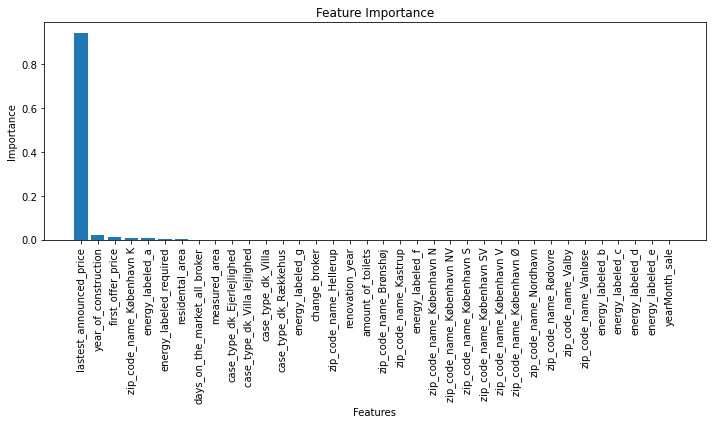

In [37]:
# Get feature importances
importances = rf_model.feature_importances_

# Get feature names
feature_names = X.columns

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance")
plt.tight_layout()
plt.show()

#### Same model for different scaled data

In [38]:
 # Create a random forest regressor & Fit for Standard scaled data
rf_model = RandomForestRegressor(n_estimators=300, min_samples_leaf=4, max_depth=5, min_samples_split=10, random_state=42).fit(X_train_standard_scaled, y_train)

# Make predictions on the testing data
y_pred = rf_model.predict(X_test_standard_scaled)

# Calculate mean squared error
mse = metrics.mean_squared_error(y_test, y_pred)

# Calculate R-squared
r2 = metrics.r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)
print("Training Score", rf_model.score(X_train_standard_scaled, y_train))
print("Test score;", rf_model.score(X_test_standard_scaled,y_test))

Mean Squared Error: 1876924947492.5635
R-squared: 0.687351715325127
Training Score 0.7813685487144494
Test score; 0.687351715325127


In [39]:
 # Create a random forest regressor & Fit for MinMax scaled data
rf_model = RandomForestRegressor(n_estimators=300, min_samples_leaf=4, max_depth=5, min_samples_split=10, random_state=42).fit(X_train_MinMax_scaled, y_train)

# Make predictions on the testing data
y_pred = rf_model.predict(X_test_MinMax_scaled)

# Calculate mean squared error
mse = metrics.mean_squared_error(y_test, y_pred)

# Calculate R-squared
r2 = metrics.r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)
print("Training Score", rf_model.score(X_train_MinMax_scaled, y_train))
print("Test score;", rf_model.score(X_test_MinMax_scaled,y_test))

Mean Squared Error: 1876955879956.2808
R-squared: 0.6873465627580331
Training Score 0.7813703877618895
Test score; 0.6873465627580331


#### Random forest comparison of scores with different n-estimators 

##### With non-scaled data

In [48]:
n=list(range(20,500,20))

train_scores.clear()
test_scores.clear()
train_scores=[]
test_scores=[]
j=0

for i in n:
    
    clf_rf=RandomForestRegressor(n_estimators=i, min_samples_leaf=4, max_depth=5, min_samples_split=10, random_state=42).fit(X_train,y_train)
    train_scores.append(clf_rf.score(X_train,y_train))
    test_scores.append(clf_rf.score(X_test,y_test))
    print ("{})  For n_estimators = {}, the train score is : {:.3f} and the test score is: {:.3f} \n".format(j+1 ,n[j], train_scores[j], test_scores[j]))
    j+=1



1)  For n_estimators = 20, the train score is : 0.776 and the test score is: 0.694 

2)  For n_estimators = 40, the train score is : 0.778 and the test score is: 0.686 

3)  For n_estimators = 60, the train score is : 0.782 and the test score is: 0.686 

4)  For n_estimators = 80, the train score is : 0.781 and the test score is: 0.684 

5)  For n_estimators = 100, the train score is : 0.780 and the test score is: 0.684 

6)  For n_estimators = 120, the train score is : 0.781 and the test score is: 0.686 

7)  For n_estimators = 140, the train score is : 0.781 and the test score is: 0.686 

8)  For n_estimators = 160, the train score is : 0.781 and the test score is: 0.687 

9)  For n_estimators = 180, the train score is : 0.781 and the test score is: 0.687 

10)  For n_estimators = 200, the train score is : 0.780 and the test score is: 0.686 

11)  For n_estimators = 220, the train score is : 0.781 and the test score is: 0.687 

12)  For n_estimators = 240, the train score is : 0.781 

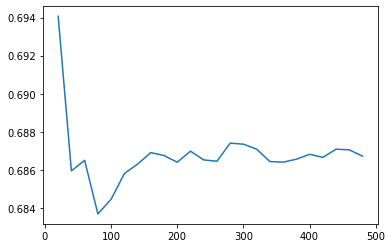

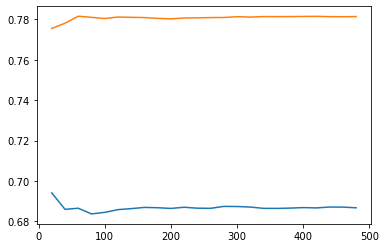

In [49]:
# Plot the test results


# x axis - a list of the values for number of estimators
x = n
# two arguments to plot are the x axis values and the y axis values
# y axis - list of test scores
plt.plot(x, test_scores)
# finally, to show the plots
plt.show()


# Plot the difference between training scores and testing scores

# x axis - a list of the values for number of estimators
x = n
# y axis - list of train scores
# two arguments to plot are the x axis values and the y axis values
plt.plot(x , test_scores)
# do another plot, with same x axis, and on the y axis - list of test scores
plt.plot(x,train_scores)
# finally, to show the plots
plt.show()

##### With standard scaled data

In [50]:
n=list(range(20,500,20))

train_scores.clear()
test_scores.clear()
train_scores=[]
test_scores=[]
j=0

for i in n:
    
    clf_rf_scaled=RandomForestRegressor(n_estimators=i, min_samples_leaf=4, max_depth=5, min_samples_split=10, random_state=42).fit(X_train_standard_scaled,y_train)
    train_scores.append(clf_rf_scaled.score(X_train_standard_scaled,y_train))
    test_scores.append(clf_rf_scaled.score(X_test_standard_scaled,y_test))
    print ("{})  For n_estimators = {}, the train score is : {:.3f} and the test score is: {:.3f} \n".format(j+1 ,n[j], train_scores[j], test_scores[j]))
    j+=1

1)  For n_estimators = 20, the train score is : 0.776 and the test score is: 0.694 

2)  For n_estimators = 40, the train score is : 0.778 and the test score is: 0.686 

3)  For n_estimators = 60, the train score is : 0.782 and the test score is: 0.686 

4)  For n_estimators = 80, the train score is : 0.781 and the test score is: 0.684 

5)  For n_estimators = 100, the train score is : 0.780 and the test score is: 0.684 

6)  For n_estimators = 120, the train score is : 0.781 and the test score is: 0.686 

7)  For n_estimators = 140, the train score is : 0.781 and the test score is: 0.686 

8)  For n_estimators = 160, the train score is : 0.781 and the test score is: 0.687 

9)  For n_estimators = 180, the train score is : 0.781 and the test score is: 0.687 

10)  For n_estimators = 200, the train score is : 0.780 and the test score is: 0.686 

11)  For n_estimators = 220, the train score is : 0.781 and the test score is: 0.687 

12)  For n_estimators = 240, the train score is : 0.781 

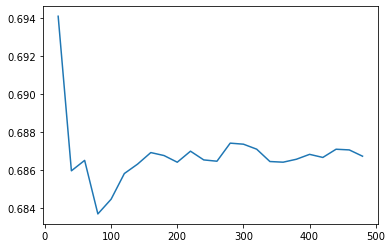

In [51]:
#Plot the results for scaled data

# x axis - a list of the values for number of estimators
x = n
# two arguments to plot are the x axis values and the y axis values
# y axis - list of test scores
plt.plot(x, test_scores)
# finally, to show the plots
plt.show()

# Neural Networks: Multilayer Perceptron (MLP)

In [52]:
# This is the list with the units of each different for the sizes of the hidden layers
units = list(range(1,100,5))

#I create empty lists where i will save the results of MLP for the different combinations of hidden layers with NON-scaled data
mlp1_train_score=list()
mlp1_test_score=list()
mlp2_train_score=list()
mlp2_test_score=list()




# Just printing a title
print("For the MLP model fit in the NON-scaled data with a SINGLE layer and different hidden sizes the results are:\n") 
print(" Size Layer 1   -   Size Layer 2  -  Train Score  -   Test Score   -   Train Scaled   -   Test Scaled")

# A loop where the MLP classifier will be fit with the different units for the NON-scaled data
for i in units: 
        for n in units: 
                #Not scaled data
        
                mlp1clf=MLPRegressor(hidden_layer_sizes= (i, n), random_state=42).fit(X_train,y_train)

                # I add to the list each of the scores of the iteration

                mlp1_train_score.append(mlp1clf.score(X_train,y_train))
                mlp1_test_score.append(mlp1clf.score(X_test,y_test))
                

                

                #Scaled data

                mlp2clf=MLPRegressor(hidden_layer_sizes= (i, n), random_state=42).fit(X_train_standard_scaled,y_train)

                # I add to the list each of the scores of the iteration

                mlp2_train_score.append(mlp2clf.score(X_train_standard_scaled,y_train))
                mlp2_test_score.append(mlp2clf.score(X_test_standard_scaled,y_test))
                

                #While looping printing the results 
                print("{:13.0f}{:19.0f}{:16.3f}{:16.3f}{:16.3f}{:16.3f}".format(i,n,mlp1clf.score(X_train,y_train), mlp1clf.score(X_test,y_test), mlp2clf.score(X_train_standard_scaled,y_train), mlp2clf.score(X_test_standard_scaled,y_test)))


For the MLP model fit in the NON-scaled data with a SINGLE layer and different hidden sizes the results are:

 Size Layer 1   -   Size Layer 2  -  Train Score  -   Test Score   -   Train Scaled   -   Test Scaled
            1                  1          -1.880          -1.824          -1.827          -1.774
            1                  6           0.753           0.707           0.003          -0.002
            1                 11           0.752           0.706           0.105           0.092
            1                 16           0.753           0.707           0.124           0.109
            1                 21           0.753           0.707           0.180           0.159
            1                 26           0.753           0.707           0.197           0.175
            1                 31           0.753           0.708           0.229           0.205
            1                 36           0.753           0.707           0.220           0.196
            

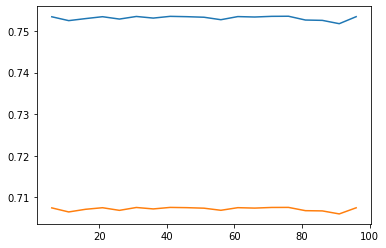

In [70]:
# x axis - a list of the values for number of estimators
x= units[1:20]
# y axis - list of train scores
# two arguments to plot are the x axis values and the y axis values
plt.plot(x,mlp1_train_score[1:20])
# do another plot, with same x axis, and on the y axis - list of test scores
plt.plot(x,mlp1_test_score[1:20])
# finally need to show the plots

plt.show()

In [ ]:
# x axis - a list of the values for number of estimators
x=units[1:20]
# y axis - list of train scores
# two arguments to plot are the x axis values and the y axis values
plt.plot(x,mlp2_train_score)
# do another plot, with same x axis, and on the y axis - list of test scores
plt.plot(x,mlp2_test_score)
# finally need to show the plots

plt.show()

In [53]:
#For Min Max scaled data


#I create empty lists where i will save the results of MLP for the different combinations of hidden layers with SCALED data
mlp3_train_score=list()
mlp3_test_score=list()


# Just printing a title
print("\n\nFor the MLP model fit in the SCALED MinMax data with a SINGLE layer and different hidden sizes the results are:\n") 
print(" Size Layer 1   -   Size Layer 2  -  Train Score  -   Test Score")

# A loop where the MLP classifier will be fit with the different units for the SCALED MinMax data
# I used the old units list
for i in units: 
        for n in units: 
        
                mlp3clf=MLPRegressor(hidden_layer_sizes= (i, n), random_state=42).fit(X_train_MinMax_scaled,y_train)

                # I add to the list each of the scores of the iteration

                mlp3_train_score.append(mlp3clf.score(X_train_MinMax_scaled,y_train))
                mlp3_test_score.append(mlp3clf.score(X_test_MinMax_scaled,y_test))
                

                #While looping printing the results 
                print("{:13.0f}{:19.0f}{:16.3f}{:16.3f}".format(i,n, mlp3clf.score(X_train_MinMax_scaled,y_train), mlp3clf.score(X_test_MinMax_scaled,y_test)))



For the MLP model fit in the SCALED MinMax data with a SINGLE layer and different hidden sizes the results are:

 Size Layer 1   -   Size Layer 2  -  Train Score  -   Test Score
            1                  1          -1.880          -1.824
            1                  6          -0.073          -0.072
            1                 11          -0.425          -0.414
            1                 16          -1.867          -1.812
            1                 21           0.198           0.195
            1                 26           0.244           0.239
            1                 31           0.234           0.229
            1                 36           0.244           0.239
            1                 41           0.272           0.267
            1                 46           0.282           0.276
            1                 51           0.306           0.300
            1                 56           0.336           0.329
            1                 61        

In [73]:

# Define your MLP model
mlp = MLPRegressor()

# Define the hyperparameters and their possible values for tuning
parameters = {
    "hidden_layer_sizes": [(100,), (50, 50), (50, 100, 50)],  # Vary the number of neurons and layers
    "activation": ["relu", "tanh"],  # Activation functions to try
    "learning_rate": ["constant", "adaptive"],  # Learning rate options
    "alpha": [0.0001, 0.001, 0.01, 10, 100]  # Regularization parameter values
}

# Define custom scoring functions for RMSE and R-squared
scoring = {
    "RMSE": make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred))),
    "R-squared": make_scorer(r2_score)
}

# Create a GridSearchCV object with your MLP model, the defined parameters, and the scoring functions
grid_search = GridSearchCV(mlp, parameters, scoring=scoring, refit="RMSE", cv=5)

# Perform hyperparameter tuning on your data
grid_search.fit(X_train_standard_scaled, y_train)  # X_train and y_train are your training data

# Get the best hyperparameters and the corresponding model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test_standard_scaled)  # X_test is your test data
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print the best hyperparameters and the evaluation metrics
print("Best Hyperparameters:", best_params)
print("RMSE:", rmse)
print("R-squared:", r2)




Best Hyperparameters: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'adaptive'}
RMSE: 4115971.3781860205
R-squared: -1.8219793769976649


NotFittedError: This MLPRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [77]:
mpl_tunned_scaled=MLPRegressor(activation="tanh",hidden_layer_sizes=(50,100,50),learning_rate="adaptive",alpha=0.001).fit(X_train_standard_scaled,y_train)



# Assuming y_true contains the true target values and y_pred contains the predicted values

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# R-squared (coefficient of determination)
r2 = r2_score(y_test, y_pred)

# Print the scores
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)


Mean Squared Error: 16941220386046.53
Mean Absolute Error: 3307251.0021203747
R-squared: -1.8219793769976649


In [80]:
mpl_tunned=MLPRegressor(activation="relu",hidden_layer_sizes=(50,100,50),learning_rate="adaptive",alpha=0.001,random_state=42).fit(X_train,y_train)


# Assuming y_true contains the true target values and y_pred contains the predicted values

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# R-squared (coefficient of determination)
r2 = r2_score(y_test, y_pred)

# Print the scores
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)

Mean Squared Error: 16941220386046.53
Mean Absolute Error: 3307251.0021203747
R-squared: -1.8219793769976649


In [ ]:
# x axis - a list of the values for number of estimators
x=units
# y axis - list of train scores
# two arguments to plot are the x axis values and the y axis values
plt.plot(x,mlp3_train_score)
# do another plot, with same x axis, and on the y axis - list of test scores
plt.plot(x,mlp3_test_score)
# finally need to show the plots

plt.show()

# Code to predict real house prices


In [49]:

# Create a dictionary with the feature values
new_sample = {
    "yearMonth_sale": 202301,
    "residental_area": 90,
    "measured_area": 90,
    "amount_of_toilets": 1 ,
    "year_of_construction": 1865, 
    "renovation_year": 0 ,
    "first_offer_price": 3495000, 
    "lastest_announced_price": 3295000 , 
    "days_on_the_market_all_broker": 180 , 
    "change_broker": 0, 
    'energy_labeled_required':0,
    'case_type_dk_Ejerlejlighed':0,
    'case_type_dk_Rækkehus':1,
    'case_type_dk_Villa':0,
    'case_type_dk_Villa lejlighed':0,
    'zip_code_name_Brønshøj':0,
    'zip_code_name_Hellerup':0,
    'zip_code_name_Kastrup':0,
    'zip_code_name_København K':0,
    'zip_code_name_København N':0,
    'zip_code_name_København NV':0,
    'zip_code_name_København S':0,
    'zip_code_name_København SV':0,
    'zip_code_name_København V':0,
    'zip_code_name_København Ø':0,
    'zip_code_name_Nordhavn':0,
    'zip_code_name_Rødovre':0,
    'zip_code_name_Valby':0,
    'zip_code_name_Vanløse':0,
    'energy_labeled_a':0,
    'energy_labeled_b':0,
    'energy_labeled_c':0,
    'energy_labeled_d':0,
    'energy_labeled_e':0,
    'energy_labeled_f':0,
    'energy_labeled_g':0

} 
#INFO FROM THE HOUSE :  3mil sold price --->  "case_type_dk": "Rækkehus"  ---> "zip_code_name": "Dragoer",---> "energy_labeled": "g", 

# Create a DataFrame from the new sample
new_sample_df = pd.DataFrame([new_sample])

# Perform one-hot encoding on categorical features
#new_sample_encoded = pd.get_dummies(new_sample_df)

# Make a prediction on the new sample randome forest
#predicted_price = rf_model.predict(new_sample_df)

#print("Predicted Price Random forest:", predicted_price)

# Make a prediction on the new sample Linear regression
#predicted_price100 = linear_reg.predict(new_sample_df)

#print("Predicted Price Linear regressor:", predicted_price100)

predicted_price10 = ridge_reg_tunned_scaled.predict(new_sample_df)

print("Predicted Price Linear regressor:", predicted_price10)

#MLP non-scaled trained in data
#predicted_price2 = mlp1clf.predict(new_sample_df)

#print("Predicted Price MLP1:", predicted_price2)

#MLP in standard scaled data

#predicted_price3 = mlp2clf.predict(new_sample_df)

#print("Predicted Price MLP2: ", predicted_price3)

#MLP in Min Max scaled data

#predicted_price4 = mlp3clf.predict(new_sample_df)

#print("Predicted Price MLP3:", predicted_price4)

#predicted_price

Predicted Price Linear regressor: [-1.03188567e+13]


#### In order to prompt a new sample and predict the price 

In [ ]:
    

    "yearMonth_sale": 202301,
    "residental_area": 90,
    "measured_area": 150,
    "amount_of_toilets": 1 ,
    "year_of_construction": 1865, 
    "renovation_year": 1 ,
    "first_offer_price": 3495000, 
    "lastest_announced_price": 3295000 , 
    "days_on_the_market_all_broker": 180 , 
    "change_broker": 0, 
    'energy_labeled_required':0,
    'case_type_dk_Ejerlejlighed':0,
    'case_type_dk_Rækkehus':1,
    'case_type_dk_Villa':0,
    'case_type_dk_Villa lejlighed':0,
    'zip_code_name_Brønshøj':0,
    'zip_code_name_Hellerup':0,
    'zip_code_name_Kastrup':0,
    'zip_code_name_København K':0,
    'zip_code_name_København N':0,
    'zip_code_name_København NV':0,
    'zip_code_name_København S':0,
    'zip_code_name_København SV':0,
    'zip_code_name_København V':0,
    'zip_code_name_København Ø':0,
    'zip_code_name_Nordhavn':0,
    'zip_code_name_Rødovre':0,
    'zip_code_name_Valby':0,
    'zip_code_name_Vanløse':0,
    'energy_labeled_a':0,
    'energy_labeled_b':0,
    'energy_labeled_c':0,
    'energy_labeled_d':0,
    'energy_labeled_e':0,
    'energy_labeled_f':0,
    'energy_labeled_g':0
